In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from fcclassifier import *

In [2]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: GeForce RTX 2080 Ti


In [3]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r"http\S+", "", text)
    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    text=text.replace("#","")

    return text

In [4]:
data = pd.read_csv('/home/nazaninjafar/ds4cg2020/bert-covid/data/alldata2.tsv')
meta_data=pd.read_csv('/home/nazaninjafar/ds4cg2020/bert-covid/data/user_metadata.tsv')
meta_data=meta_data.replace(np.nan, '', regex=True)

In [5]:
from sklearn.preprocessing import normalize
def norm(X):
    X=normalize(X, axis=0, norm='max')
    return X

# User metadata features:

In [6]:
fc = np.expand_dims((meta_data.friend_count.values), axis=1)
fwc = np.expand_dims(meta_data.follower_count.values, axis=1)
favc = np.expand_dims(meta_data.fav_count.values, axis=1)
tc = np.expand_dims(meta_data.tweet_count.values, axis=1)
TFF=fc+1/fwc+1


In [7]:
creation_times=meta_data.created.values

In [8]:
import datetime
from datetime import timedelta
# import datetime

today = datetime.datetime.today()
print(today)
time_difference=[]
for a in creation_times:
    account_date=datetime.datetime.strptime(a, '%Y-%m-%d %H:%M:%S')
    time_difference.append((today - account_date).days)
#     print(time_difference)
# age=[(today - account_date).days for ]

2020-08-03 13:35:54.666334


In [9]:
age=np.array(time_difference).reshape(-1,1)

In [10]:
md_X=np.concatenate((favc,tc,TFF,age),axis=1)
md_X=norm(md_X)

In [11]:
# from sklearn.model_selection import train_test_split

# X = data.tweet.values
# y = data.label.values
# indices = np.arange(len(X))
# train_idx, val_idx, y_train, y_val= train_test_split(indices, y,stratify = y, test_size=0.2, random_state=42)
# X_train = X[train_idx]
# X_val = X[val_idx]
# mdX_train = md_X[train_idx]
# mdX_val = md_X[val_idx]

In [12]:


# X_train, X_val, y_train, y_val =\
#     train_test_split(X, y,stratify = y, test_size=0.1, random_state=42)
# mdX_train, mdX_val, y_train, y_val =\
#     train_test_split(md_X, y,stratify = y, test_size=0.1, random_state=42)

In [13]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Create a function to tokenize a set of texts
def preprocessing_for_ctbert(data,max_len):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_len,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,     # Return attention mask
            truncation=True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [14]:
# print('Tokenizing data...')
# max_len = 160
# train_inputs, train_masks = preprocessing_for_ctbert(X_train,max_len)
# val_inputs, val_masks = preprocessing_for_ctbert(X_val,max_len)

In [15]:
learningrate=5e-5
from transformers import AdamW, get_linear_schedule_with_warmup
from fcclassifier import *
# from bertmodel import *
def initialize_model(epochs=4,lr=learningrate):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
#     bert_model = BertM(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    classifier=MergedClassifier()
    
    classifier.to(device)
    # Create the optimizer
    optimizer = AdamW(classifier.parameters(),
                      lr=learningrate,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return classifier, optimizer, scheduler

In [16]:
import random
import time
import torch.nn as nn
from fcclassifier import *
# from bertmodel import *
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(classifier, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} |{'Train Acc':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        classifier.train()
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask,b_md, b_labels = tuple(t.to(device) for t in batch)
            
            # Zero out any previously calculated gradients
#             bertmodel.zero_grad()
            classifier.zero_grad()
            # Perform a forward pass. This will return logits.
            logits = classifier(b_input_ids, b_attn_mask,b_md)
            
#             #concatenating the hidden state with metadata:
#             out=torch.cat((h_state,b_md),axis=1)
#             print(out.size())  
              
#             logits = classifier(out)
            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(classifier.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy,_ = evaluate(classifier, val_dataloader)
            _,train_accuracy,_=evaluate(classifier,train_dataloader)
            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {train_accuracy:^9.2f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(classifier, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    classifier.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    preds=[]

    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask,b_md, b_labels = tuple(t.to(device) for t in batch)
        # Compute logits
        with torch.no_grad():
            logits = classifier(b_input_ids, b_attn_mask,b_md)
            #concatenating the hidden state with metadata:
#             out=torch.cat((h_state,b_md),axis=1)
            
#             logits = classifier(out)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        pred= torch.argmax(logits, dim=1).flatten()
        preds.append(pred)
        # Calculate the accuracy rate
        accuracy = (pred == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy,preds

In [17]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
def cval_eval(val_loss,val_accuracy,preds,y_val):
        metrics={}
        np_preds=[]
        for i in preds:
            b=i.cpu().detach().numpy()
            np_preds=np.append(np_preds,b,axis=0)
        metrics['val_accuracy']=val_accuracy
        metrics['f1']=f1_score(y_val, np_preds, average=None)
        metrics['precision']=precision_score(y_val, np_preds, average=None)
    #     metrics['precision']=average_precision_score(y_val, probs)
        metrics['recall']=recall_score(y_val, np_preds, average=None)
        print(metrics)
        
        return metrics

In [18]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask,b_md,b_label = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask,b_md)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [19]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
#     # Get accuracy over the test set
#     y_pred = np.where(preds >= 0.5, 1, 0)
#     accuracy = accuracy_score(y_true, y_pred)
#     print(f'Accuracy: {accuracy*100:.2f}%')
    
#     # Plot ROC AUC
#     plt.title('Receiver Operating Characteristic')
#     plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()

In [20]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
X = data.tweet.values
y = data.label.values
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
StratifiedKFold(n_splits=10, random_state=None, shuffle=False)



batch_size=32
max_length = 160
# kf = KFold(n_splits=5)
# kf.get_n_splits(X)
# print(kf)
epochs=20
learningrate=5e-5
# KFold(n_splits=5, random_state=None, shuffle=True)

auc=[]
acc=[]
prec=[]
recall=[]
f1=[]
i=1
for train_index, test_index in skf.split(X, y):
#         print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_val,mdX_train,mdX_val = X[train_index], X[test_index],md_X[train_index],md_X[test_index]
        y_train, y_val = y[train_index], y[test_index]
#         train_file='train'+str(i)+'.pkl'
#         tlabel_file='tlabel'+str(i)+'.pkl'
#         val_file='val'+str(i)+'.pkl'
#         valabelfile='valabel'+str(i)+'.pkl'
#         with open(train_file,'wb') as f:
#              pickle.dump(X_train, f)
#         with open(tlabel_file,'wb') as f:
#              pickle.dump(y_train, f)
#         with open(val_file,'wb') as f:
#              pickle.dump(X_val, f)
#         with open(valabelfile,'wb') as f:
#              pickle.dump(y_val, f)
        print(y_val)
        print(y_val.shape)
        train_inputs, train_masks = preprocessing_for_ctbert(X_train,max_length)
        val_inputs, val_masks = preprocessing_for_ctbert(X_val,max_length)
        # Convert other data types to torch.Tensor
        train_labels = torch.tensor(y_train)
        val_labels = torch.tensor(y_val)


        md_train=torch.tensor(mdX_train).type(torch.FloatTensor)
        md_val=torch.tensor(mdX_val).type(torch.FloatTensor)

        # Create the DataLoader for our training set
        train_data = TensorDataset(train_inputs, train_masks,md_train, train_labels)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

        # Create the DataLoader for our validation set
        val_data = TensorDataset(val_inputs, val_masks,md_val, val_labels)
        val_sampler = SequentialSampler(val_data)
        val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
        
        
        ctbert_classifier, optimizer, scheduler = initialize_model(epochs,learningrate)
        set_seed(42)    # Set seed for reproducibility
        train(ctbert_classifier, train_dataloader, val_dataloader, epochs, evaluation=True)
        # Compute predicted probabilities on the test set
        probs = bert_predict(ctbert_classifier, val_dataloader)
#         print(probs)
#         print(probs.shape)
#         evaluate_roc(probs, y_val)
        val_loss,val_accuracy,preds= evaluate(ctbert_classifier, val_dataloader)
        metrics=cval_eval(val_loss,val_accuracy,preds,y_val)
        print(metrics['val_accuracy'])
      # append model score
        acc.append(metrics['val_accuracy'])
        f1.append(metrics['f1'])
        recall.append(metrics['recall'])
        prec.append(metrics['precision'])
        

print("auc: ",auc)
print("accuracy: ",acc)
# print("f1: ",f1)
print("recall: ",recall)
# print(f"Mean-acc: {sum(auc) / len(auc)}")
print(f"Mean-acc: {sum(acc) / len(acc)}")
print(f"Mean-f1: {sum(f1) / len(f1)}")
print(f"Mean-recall: {sum(recall) / len(recall)}")
print(f"Mean-Precision: {sum(prec) / len(prec)}")

[1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1
 0 0 1 1 0 1 0 0]
(45,)
Start training...

 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   12    |   0.688314   |     -      |     -     |   4.17   
----------------------------------------------------------------------
   1    |    -    |   0.688314   |   57.56   |  0.675513  |   55.05   |   5.60   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   12    |   0.640616   |     -      |     -     |   4.06   
----------------------------------------------------------------------
   2    |    -    |   0.640616   |   86.51   |  0.659778  |   53.49   |   5.50   
-----------------------------------------------------

  19    |   12    |   0.246136   |     -      |     -     |   4.07   
----------------------------------------------------------------------
  19    |    -    |   0.246136   |   99.28   |  0.868916  |   66.59   |   5.54   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  20    |   12    |   0.251361   |     -      |     -     |   4.16   
----------------------------------------------------------------------
  20    |    -    |   0.251361   |   99.28   |  0.874644  |   66.59   |   5.64   
----------------------------------------------------------------------


Training complete!
{'val_accuracy': 66.58653846153847, 'f1': array([0.56410256, 0.66666667]), 'precision': array([0.57894737, 0.65384615]), 'recall': array([0.55, 0.68])}
66.58653846153847
[1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1

  17    |   12    |   0.274918   |     -      |     -     |   4.22   
----------------------------------------------------------------------
  17    |    -    |   0.274918   |   98.29   |  0.706345  |   65.14   |   5.69   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  18    |   12    |   0.269099   |     -      |     -     |   4.22   
----------------------------------------------------------------------
  18    |    -    |   0.269099   |   98.56   |  0.709252  |   65.14   |   5.70   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  19    |   12    |   0.269287   |     -      |     -     |   4.21   
----------------------------

  15    |   12    |   0.272495   |     -      |     -     |   4.21   
----------------------------------------------------------------------
  15    |    -    |   0.272495   |   99.04   |  0.489837  |   83.77   |   5.68   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  16    |   12    |   0.265933   |     -      |     -     |   4.32   
----------------------------------------------------------------------
  16    |    -    |   0.265933   |   98.77   |  0.491447  |   83.77   |   5.80   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  17    |   12    |   0.262078   |     -      |     -     |   4.30   
----------------------------

  13    |   12    |   0.285773   |     -      |     -     |   4.29   
----------------------------------------------------------------------
  13    |    -    |   0.285773   |   98.80   |  0.676291  |   69.83   |   5.78   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  14    |   12    |   0.279758   |     -      |     -     |   4.40   
----------------------------------------------------------------------
  14    |    -    |   0.279758   |   98.53   |  0.670699  |   69.83   |   5.89   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  15    |   12    |   0.274821   |     -      |     -     |   4.31   
----------------------------

  11    |   12    |   0.313173   |     -      |     -     |   4.25   
----------------------------------------------------------------------
  11    |    -    |   0.313173   |   98.32   |  0.514536  |   77.52   |   5.72   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  12    |   12    |   0.306389   |     -      |     -     |   4.23   
----------------------------------------------------------------------
  12    |    -    |   0.306389   |   98.32   |  0.526173  |   79.09   |   5.71   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  13    |   12    |   0.292103   |     -      |     -     |   4.28   
----------------------------

   9    |   12    |   0.334356   |     -      |     -     |   4.28   
----------------------------------------------------------------------
   9    |    -    |   0.334356   |   99.04   |  0.656279  |   68.99   |   5.77   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  10    |   12    |   0.314191   |     -      |     -     |   4.29   
----------------------------------------------------------------------
  10    |    -    |   0.314191   |   99.04   |  0.502269  |   76.68   |   5.76   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  11    |   12    |   0.299962   |     -      |     -     |   4.27   
----------------------------

   7    |   12    |   0.363672   |     -      |     -     |   4.29   
----------------------------------------------------------------------
   7    |    -    |   0.363672   |   98.80   |  0.552278  |   72.12   |   5.77   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   8    |   12    |   0.342623   |     -      |     -     |   4.28   
----------------------------------------------------------------------
   8    |    -    |   0.342623   |   99.28   |  0.571368  |   70.55   |   5.75   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   9    |   12    |   0.338173   |     -      |     -     |   4.30   
----------------------------

   5    |   12    |   0.418977   |     -      |     -     |   4.23   
----------------------------------------------------------------------
   5    |    -    |   0.418977   |   98.80   |  0.548934  |   73.86   |   5.70   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   6    |   12    |   0.379468   |     -      |     -     |   4.26   
----------------------------------------------------------------------
   6    |    -    |   0.379468   |   99.04   |  0.496781  |   81.53   |   5.74   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   7    |   12    |   0.355726   |     -      |     -     |   4.29   
----------------------------

   3    |   12    |   0.555871   |     -      |     -     |   4.29   
----------------------------------------------------------------------
   3    |    -    |   0.555871   |   92.07   |  0.557243  |   78.41   |   5.76   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   4    |   12    |   0.496568   |     -      |     -     |   4.29   
----------------------------------------------------------------------
   4    |    -    |   0.496568   |   94.71   |  0.521192  |   82.95   |   5.77   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   5    |   12    |   0.433985   |     -      |     -     |   4.33   
----------------------------

Start training...

 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   12    |   0.697804   |     -      |     -     |   4.27   
----------------------------------------------------------------------
   1    |    -    |   0.697804   |   57.92   |  0.660376  |   62.93   |   5.74   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   12    |   0.655793   |     -      |     -     |   4.25   
----------------------------------------------------------------------
   2    |    -    |   0.655793   |   77.25   |  0.591413  |   82.81   |   5.73   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elap

  19    |   12    |   0.233414   |     -      |     -     |   4.26   
----------------------------------------------------------------------
  19    |    -    |   0.233414   |   98.59   |  0.300664  |   93.75   |   5.74   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  | Train Acc   |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  20    |   12    |   0.235827   |     -      |     -     |   4.30   
----------------------------------------------------------------------
  20    |    -    |   0.235827   |   98.80   |  0.300429  |   93.75   |   5.78   
----------------------------------------------------------------------


Training complete!
{'val_accuracy': 93.75, 'f1': array([0.88888889, 0.92      ]), 'precision': array([0.94117647, 0.88461538]), 'recall': array([0.84210526, 0.95833333])}
93.75
auc:  []
accuracy:  [66.58653846153847, 65.14423076923077, 83.77403846153847

In [21]:
md_X.shape[1]

4

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
val_loss, val_accuracy,y_pred= evaluate(classifier, val_dataloader)

NameError: name 'classifier' is not defined

In [ ]:
np_preds=[]
for i in y_pred:
    b=i.cpu().detach().numpy()
    np_preds=np.append(np_preds,b,axis=0)

In [24]:
np_preds=np_preds.astype(int)

In [25]:
class_names = ['fake', 'real']
print(classification_report(y_val, np_preds, target_names=class_names))

              precision    recall  f1-score   support

        fake       0.70      0.72      0.71        39
        real       0.78      0.76      0.77        50

   micro avg       0.74      0.74      0.74        89
   macro avg       0.74      0.74      0.74        89
weighted avg       0.74      0.74      0.74        89



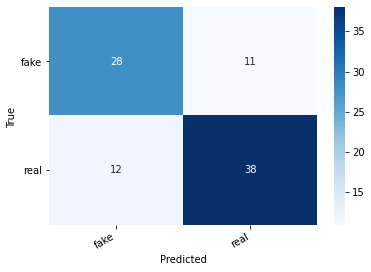

In [26]:
def show_confusion_matrix(confusion_matrix):
      hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
      hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
      hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
      plt.ylabel('True ')
      plt.xlabel('Predicted');
cm = confusion_matrix(y_val, np_preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

AUC: 0.7674
Accuracy: 74.16%


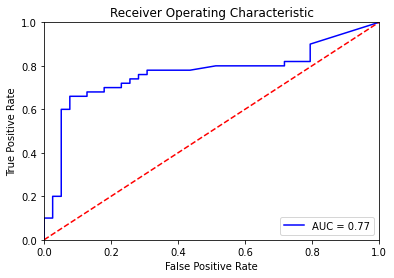

In [29]:
# Compute predicted probabilities on the test set
probs = bert_predict(classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

4 features without ratio works better than 5 features with TFF
6 features with addition of creation time is better than 5 features AUC=84.4,

             precision    recall  f1-score   support

        fake       0.82      0.70      0.76        20
        real       0.79      0.88      0.83        25
        
        
best perforimg features so far are TFF,fav_count, tweet_count and age of the created account.  AUC=94% and accuracy:84.4%
 precision    recall  f1-score   support

        fake       0.88      0.75      0.81        20
        real       0.82      0.92      0.87        25
        micro avg       0.84      0.84      0.84        45
        macro avg       0.85      0.83      0.84        45
        weighted avg       0.85      0.84      0.84        45



